In [ ]:
!pyspark --version

Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /___/ .__/\_,_/_/ /_/\_\   version 3.5.3
      /_/
                        
Using Scala version 2.12.18, OpenJDK 64-Bit Server VM, 11.0.24
Branch HEAD
Compiled by user haejoon.lee on 2024-09-09T05:20:05Z
Revision 32232e9ed33bb16b93ad58cfde8b82e0f07c0970
Url https://github.com/apache/spark
Type --help for more information.


In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.window import Window
from pyspark.sql.functions import rank, col

spark = SparkSession.builder.appName('Praktikum9').getOrCreate()

data = [
    ('James', 34, 'M', 3000, 1),
    ('Anna', 28, 'F', 4100, 2),
    ('Lee', 23, 'M', 2700, 1),
    ('Chou', 23, 'M', 3004, 3),
    ('Chui', 28, 'F', 2100, 4),
    ('Zuxhin', 34, 'F', 2500, 3)
]
columns = ['Name', 'Age', 'Gender', 'Salary', 'DeptId']
df = spark.createDataFrame(data, schema=columns)
df.createOrReplaceTempView('employees')

print( "Data Awal")
spark.sql('SELECT * FROM employees').show()

print( "Salary > 2500")
spark.sql('SELECT Name, Age FROM employees WHERE Salary > 2500').show()

print( "Average from employees")
spark.sql('SELECT AVG(Salary) FROM employees').show()

Data Awal
+------+---+------+------+------+
|  Name|Age|Gender|Salary|DeptId|
+------+---+------+------+------+
| James| 34|     M|  3000|     1|
|  Anna| 28|     F|  4100|     2|
|   Lee| 23|     M|  2700|     1|
|  Chou| 23|     M|  3004|     3|
|  Chui| 28|     F|  2100|     4|
|Zuxhin| 34|     F|  2500|     3|
+------+---+------+------+------+

Salary > 2500
+-----+---+
| Name|Age|
+-----+---+
|James| 34|
| Anna| 28|
|  Lee| 23|
| Chou| 23|
+-----+---+

Average from employees
+------------------+
|       avg(Salary)|
+------------------+
|2900.6666666666665|
+------------------+



In [ ]:
print( "Urutan Salary berdasarkan dari umur terkecil")
ratarata_salary_umur_terkecil = spark.sql('''
SELECT Gender, SUM(Salary) as TotalSalary, Age
FROM employees
GROUP BY Gender, Age
ORDER BY Age
''').show()

print("Rata rata gaji perdepartemen")
ratarata_salary_departemen = spark.sql("""
    SELECT DeptId, AVG(Salary) AS AvgSalary
    FROM employees
    GROUP BY DeptId
""").show()

print("Rata rata gaji setiap gender yang diatas rata rata ")
ratarata_salary_gender = spark.sql("""
    SELECT Gender, AVG(Salary) AS AvgSalary
    FROM employees
    GROUP BY Gender
""").show()

print("Ranking karyawan berdasarkan gaji dalam departemen ")
window_spec = Window.partitionBy("DeptId").orderBy(col("Salary").desc())
ranked_employees = df.withColumn("Rank", rank().over(window_spec))
ranked_employees.show()




Urutan Salary berdasarkan dari umur terkecil
+------+-----------+---+
|Gender|TotalSalary|Age|
+------+-----------+---+
|     M|       5704| 23|
|     F|       6200| 28|
|     M|       3000| 34|
|     F|       2500| 34|
+------+-----------+---+

Rata rata gaji perdepartemen
+------+---------+
|DeptId|AvgSalary|
+------+---------+
|     1|   2850.0|
|     2|   4100.0|
|     3|   2752.0|
|     4|   2100.0|
+------+---------+

Rata rata gaji setiap gender yang diatas rata rata 
+------+------------------+
|Gender|         AvgSalary|
+------+------------------+
|     F|            2900.0|
|     M|2901.3333333333335|
+------+------------------+

Ranking karyawan berdasarkan gaji dalam departemen 
+------+---+------+------+------+----+
|  Name|Age|Gender|Salary|DeptId|Rank|
+------+---+------+------+------+----+
| James| 34|     M|  3000|     1|   1|
|   Lee| 23|     M|  2700|     1|   2|
|  Anna| 28|     F|  4100|     2|   1|
|  Chou| 23|     M|  3004|     3|   1|
|Zuxhin| 34|     F|  2500|

In [ ]:
print("3 top kelompok usia tertentu berdasarkan salary tertinggi ")
spark.sql('''
SELECT Name, Age, Salary, ROW_NUMBER() OVER (PARTITION BY Age ORDER BY Salary DESC) as rank
FROM employees
''').show()

3 top kelompok usia tertentu berdasarkan salary tertinggi 
+------+---+------+----+
|  Name|Age|Salary|rank|
+------+---+------+----+
|  Chou| 23|  3004|   1|
|   Lee| 23|  2700|   2|
|  Anna| 28|  4100|   1|
|  Chui| 28|  2100|   2|
| James| 34|  3000|   1|
|Zuxhin| 34|  2500|   2|
+------+---+------+----+



In [ ]:
departments = spark.createDataFrame([
    (1, 'HR'),
    (2, 'Marketing'),
    (3, 'Testing'),
    (4, 'Jasa')
], ['DeptId', 'DeptName'])
projects = spark.createDataFrame([
    (1, 'Project A'),
    (2, 'Project B'),
    (3, 'Project C'),
    (4, 'Project D')
], ['DeptId', 'ProjectName'])

employees = spark.table("employees")
employees.createOrReplaceTempView('employees')
departments.createOrReplaceTempView('departments')
projects.createOrReplaceTempView('projects')


# Complex SQL query involving multiple joins and subqueries
spark.sql('''
SELECT p.ProjectName, d.DeptName, e.Name, e.Age
FROM projects p
LEFT JOIN departments d ON p.DeptId = d.DeptId
LEFT JOIN employees e ON p.DeptId = e.DeptId
''').show()



+-----------+---------+------+---+
|ProjectName| DeptName|  Name|Age|
+-----------+---------+------+---+
|  Project A|       HR|   Lee| 23|
|  Project A|       HR| James| 34|
|  Project B|Marketing|  Anna| 28|
|  Project C|  Testing|Zuxhin| 34|
|  Project C|  Testing|  Chou| 23|
|  Project D|     Jasa|  Chui| 28|
+-----------+---------+------+---+



In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

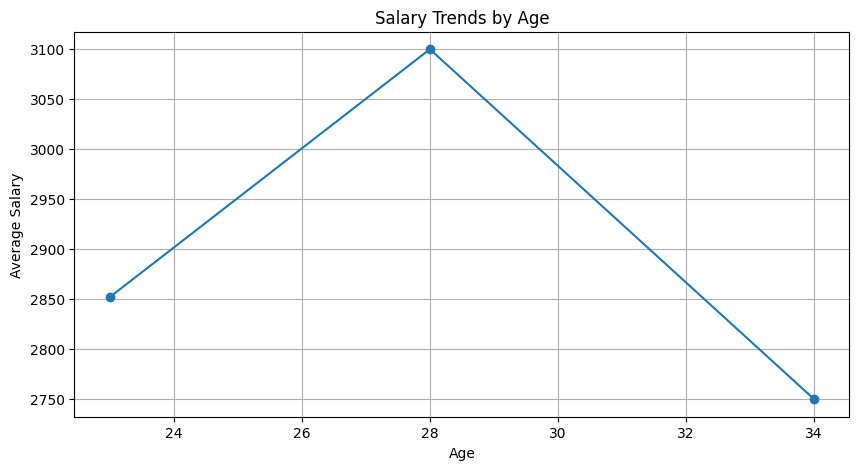

In [ ]:
# Advanced data analysis with visualization
salary_trends = spark.sql('''
SELECT Age, AVG(Salary) AS AverageSalary
FROM employees
GROUP BY Age
ORDER BY Age
''').toPandas()

# Visualization of salary trends
plt.figure(figsize=(10, 5))
plt.plot(salary_trends['Age'], salary_trends['AverageSalary'], marker='o')
plt.xlabel('Age')
plt.ylabel('Average Salary')
plt.title('Salary Trends by Age')
plt.grid(True)
plt.show()


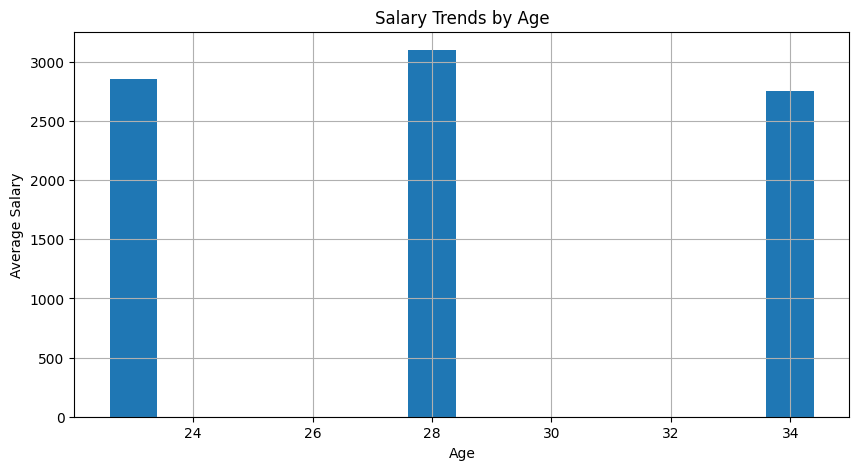

In [ ]:

# Advanced data analysis with visualization
salary_trends = spark.sql('''
SELECT Age, AVG(Salary) AS AverageSalary
FROM employees
GROUP BY Age
ORDER BY Age
''').toPandas()

# Visualization of salary trends
plt.figure(figsize=(10, 5))
plt.bar(salary_trends['Age'], salary_trends['AverageSalary'])
plt.xlabel('Age')
plt.ylabel('Average Salary')
plt.title('Salary Trends by Age')
plt.grid(True)
plt.show()

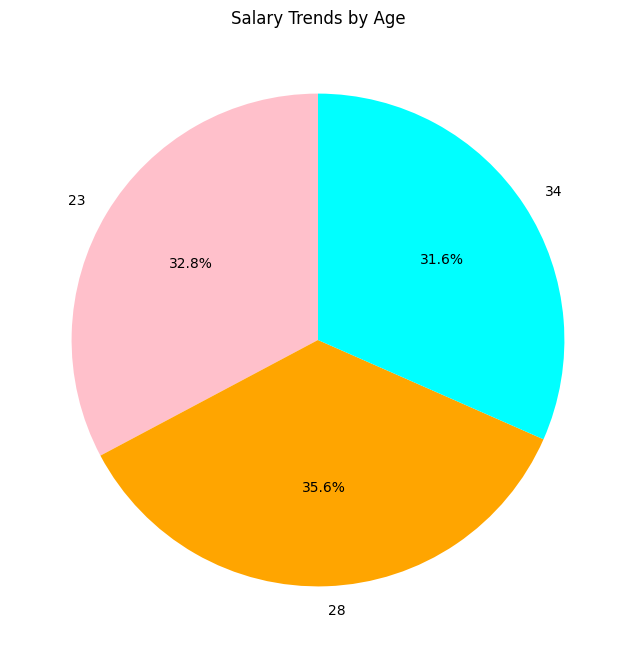

In [ ]:
# Advanced data analysis with visualization
salary_trends = spark.sql('''
SELECT Age, AVG(Salary) AS AverageSalary
FROM employees
GROUP BY Age
ORDER BY Age
''').toPandas()

# Visualization of salary trends using pie chart
colors = ['pink', 'orange', 'aqua'] # List of colors for each slice
plt.figure(figsize=(8, 8))
plt.pie(salary_trends['AverageSalary'], labels=salary_trends['Age'],
        autopct='%1.1f%%', startangle=90, colors=colors)
plt.title('Salary Trends by Age')
plt.show()

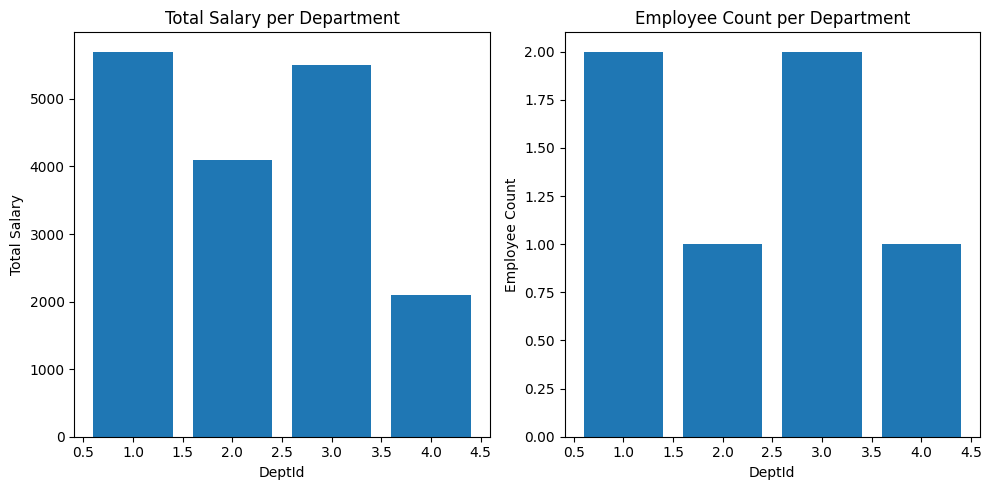

In [ ]:
# Kueri Spark SQL untuk total gaji dan jumlah karyawan per departemen
department_stats = spark.sql("""
    SELECT DeptId, SUM(Salary) AS TotalSalary, COUNT(*) AS EmployeeCount
    FROM employees
    GROUP BY DeptId
""").toPandas()

# Visualisasi menggunakan Matplotlib
plt.figure(figsize=(10, 5))

# Bar chart untuk total gaji
plt.subplot(1, 2, 1)
plt.bar(department_stats['DeptId'], department_stats['TotalSalary'])
plt.xlabel('DeptId')
plt.ylabel('Total Salary')
plt.title('Total Salary per Department')

# Bar chart untuk jumlah karyawan
plt.subplot(1, 2, 2)
plt.bar(department_stats['DeptId'], department_stats['EmployeeCount'])
plt.xlabel('DeptId')
plt.ylabel('Employee Count')
plt.title('Employee Count per Department')

plt.tight_layout()
plt.show()

+------+-----------+-------------+
|DeptId|TotalSalary|EmployeeCount|
+------+-----------+-------------+
|     1|       5700|            2|
|     2|       4100|            1|
|     3|       5504|            2|
|     4|       2100|            1|
+------+-----------+-------------+



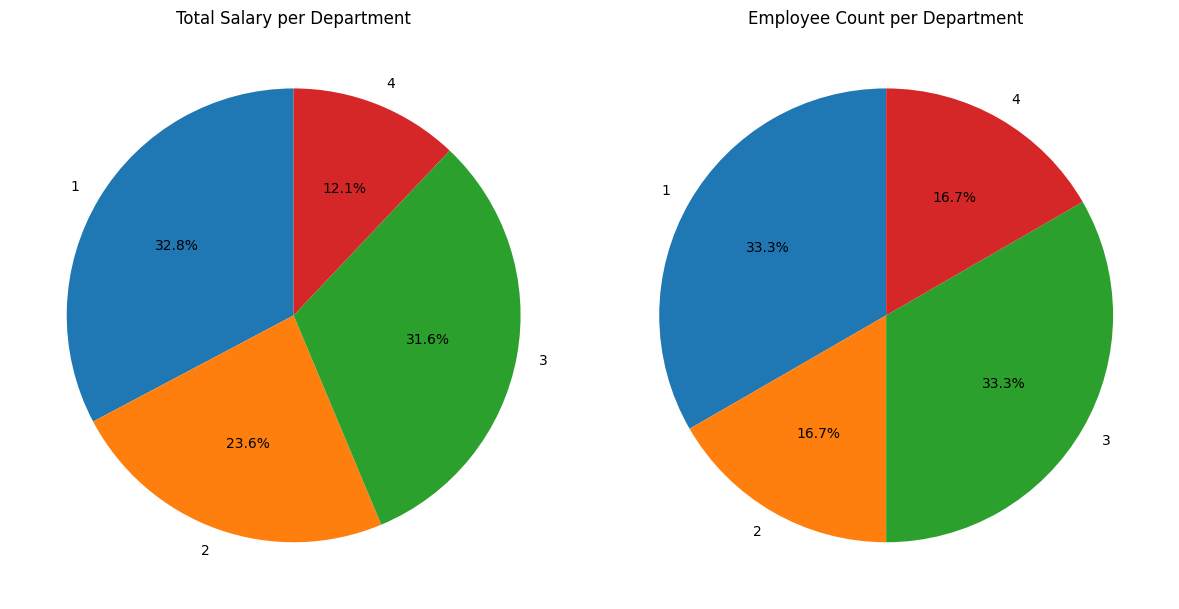

In [ ]:
# Kueri Spark SQL untuk total gaji dan jumlah karyawan per departemen
department_stats = spark.sql("""
    SELECT DeptId, SUM(Salary) AS TotalSalary, COUNT(*) AS EmployeeCount
    FROM employees
    GROUP BY DeptId
""")

department_stats.show()

department_stats_pd = department_stats.toPandas()

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.pie(department_stats_pd['TotalSalary'], labels=department_stats_pd['DeptId'], autopct='%1.1f%%', startangle=90)
plt.title('Total Salary per Department')

# Diagram lingkaran untuk jumlah karyawan
plt.subplot(1, 2, 2)
plt.pie(department_stats_pd['EmployeeCount'], labels=department_stats_pd['DeptId'], autopct='%1.1f%%', startangle=90)
plt.title('Employee Count per Department')

plt.tight_layout()
plt.show()

+---+-------------+
|Age|AverageSalary|
+---+-------------+
| 34|       2750.0|
| 28|       3100.0|
| 23|       2852.0|
+---+-------------+



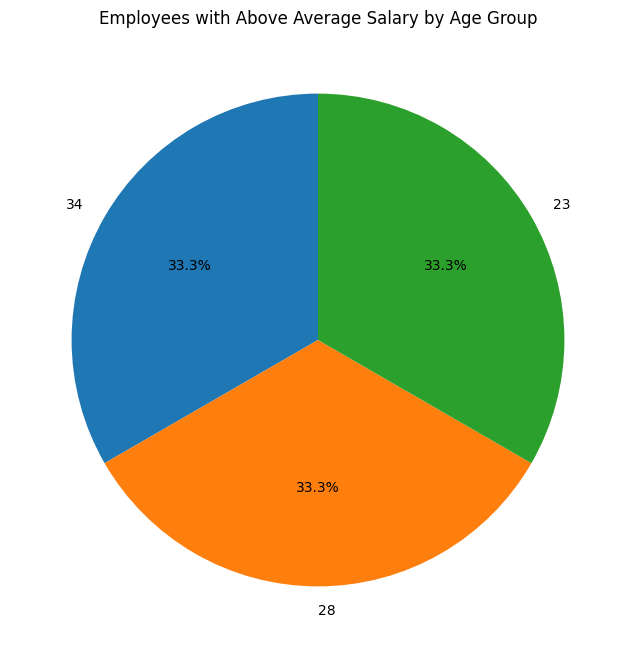

In [ ]:
avg_salary_by_age = spark.sql("""
    SELECT Age, AVG(Salary) AS AverageSalary
    FROM employees
    GROUP BY Age
""")

avg_salary_by_age.show()

above_avg_employees = spark.table("employees").join(
    avg_salary_by_age, on="Age"
).filter(col("Salary") > col("AverageSalary"))

# Hitung jumlah karyawan di atas rata-rata per kelompok usia
above_avg_count = above_avg_employees.groupBy("Age").count().toPandas()

# Visualisasi menggunakan pie chart
plt.figure(figsize=(8, 8))
plt.pie(above_avg_count['count'], labels=above_avg_count['Age'], autopct='%1.1f%%', startangle=90)
plt.title('Employees with Above Average Salary by Age Group')
plt.show()

In [ ]:
!pip install mysql-connector-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 46.5 MB/s eta 0:00:00


In [ ]:
import mysql.connector

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving cats.csv to cats.csv


In [ ]:
import pandas as pd

# Membaca file CSV
data = pd.read_csv('cats.csv')

In [ ]:
# Menampilkan beberapa baris pertama
print(data.head())

              Breed  Age  Weight           Color  Gender
0      Russian Blue   19        7  Tortoiseshell  Female
1  Norwegian Forest   19        9  Tortoiseshell  Female
2         Chartreux    3        3          Brown  Female
3           Persian   13        6          Sable  Female
4           Ragdoll   10        8          Tabby    Male


In [ ]:
# Membuat DataFrame department dan project
departments = spark.createDataFrame([
    (1, 'HR'),
    (2, 'Marketing'),
    (3, 'Testing'),
    (4, 'Jasa')
], ['DeptId', 'DeptName'])

projects = spark.createDataFrame([
    (1, 'Project A'),
    (2, 'Project B'),
    (3, 'Project C'),
    (4, 'Project D')
], ['DeptId', 'ProjectName'])

# Mengambil data karyawan dari tabel
employees = spark.table("employees")
employees.createOrReplaceTempView('employees')
departments.createOrReplaceTempView('departments')
projects.createOrReplaceTempView('projects')

# Query SQL kompleks yang melibatkan beberapa join dan subquery
result = spark.sql('''
SELECT
    p.ProjectName,
    d.DeptName,
    e.Name,
    e.Age
FROM
    projects p
LEFT JOIN
    departments d ON p.DeptId = d.DeptId
LEFT JOIN
    employees e ON p.DeptId = e.DeptId
''')

# Menampilkan hasil dari query pertama
result.show()

# Query untuk menemukan rata-rata gaji per departemen dan peringkat setiap karyawan
avg_salary_rank_query = spark.sql('''
WITH AvgSalaryPerDepartment AS (
    SELECT
        DeptId,
        AVG(Salary) AS AvgSalary
    FROM
        employees
    GROUP BY
        DeptId
),
RankedEmployees AS (
    SELECT
        e.Name,
        e.DeptId,
        e.Salary,
        ROW_NUMBER() OVER (PARTITION BY e.DeptId ORDER BY e.Salary DESC) AS Rank
    FROM
        employees e
)

SELECT
    r.Name,
    r.DeptId,
    r.Salary,
    r.Rank,
    a.AvgSalary
FROM
    RankedEmployees r
JOIN
    AvgSalaryPerDepartment a ON r.DeptId = a.DeptId
ORDER BY
    r.DeptId, r.Rank;
''')

# Menampilkan hasil dari query rata-rata gaji dan peringkat
avg_salary_rank_query.show()

# Query untuk menentukan tren gaji berdasarkan usia di setiap departemen
salary_trend_query = spark.sql('''
WITH AvgSalaryByAge AS (
    SELECT
        e.DeptId,
        e.Age,
        AVG(e.Salary) AS AvgSalary,
        ROW_NUMBER() OVER (PARTITION BY e.DeptId ORDER BY e.Age) AS AgeRank
    FROM
        employees e
    GROUP BY
        e.DeptId, e.Age
)

SELECT
    d.DeptName,
    a.Age,
    a.AvgSalary,
    a.AgeRank
FROM
    AvgSalaryByAge a
JOIN
    departments d ON a.DeptId = d.DeptId
ORDER BY
    d.DeptId, a.Age;
''')

# Menampilkan hasil tren gaji berdasarkan usia
salary_trend_query.show()

+-----------+---------+------+---+
|ProjectName| DeptName|  Name|Age|
+-----------+---------+------+---+
|  Project A|       HR|   Lee| 23|
|  Project A|       HR| James| 34|
|  Project B|Marketing|  Anna| 28|
|  Project C|  Testing|Zuxhin| 34|
|  Project C|  Testing|  Chou| 23|
|  Project D|     Jasa|  Chui| 28|
+-----------+---------+------+---+

+------+------+------+----+---------+
|  Name|DeptId|Salary|Rank|AvgSalary|
+------+------+------+----+---------+
| James|     1|  3000|   1|   2850.0|
|   Lee|     1|  2700|   2|   2850.0|
|  Anna|     2|  4100|   1|   4100.0|
|  Chou|     3|  3004|   1|   2752.0|
|Zuxhin|     3|  2500|   2|   2752.0|
|  Chui|     4|  2100|   1|   2100.0|
+------+------+------+----+---------+

+---------+---+---------+-------+
| DeptName|Age|AvgSalary|AgeRank|
+---------+---+---------+-------+
|       HR| 23|   2700.0|      1|
|       HR| 34|   3000.0|      2|
|Marketing| 28|   4100.0|      1|
|  Testing| 23|   3004.0|      1|
|  Testing| 34|   2500.0|     

In [ ]:
# Membuat DataFrame department dan project
departments = spark.createDataFrame([
    (1, 'HR'),
    (2, 'Marketing'),
    (3, 'Testing'),
    (4, 'Jasa')
], ['DeptId', 'DeptName'])

projects = spark.createDataFrame([
    (1, 'Project A'),
    (2, 'Project B'),
    (3, 'Project C'),
    (4, 'Project D')
], ['DeptId', 'ProjectName'])

# Mengambil data karyawan dari tabel
employees = spark.table("employees")
employees.createOrReplaceTempView('employees')
departments.createOrReplaceTempView('departments')
projects.createOrReplaceTempView('projects')

# Query gabungan untuk mendapatkan informasi proyek, rata-rata gaji, dan tren gaji berdasarkan usia
combined_query = spark.sql('''
WITH AvgSalaryPerDepartment AS (
    SELECT DeptId, AVG(Salary) AS AvgSalary
    FROM employees
    GROUP BY DeptId
),
SalaryTrend AS (
    SELECT
        e.DeptId,
        e.Age,
        AVG(e.Salary) AS AvgSalary,
        ROW_NUMBER() OVER (PARTITION BY e.DeptId ORDER BY e.Age) AS AgeRank
    FROM employees e
    GROUP BY e.DeptId, e.Age
)

SELECT
    p.ProjectName,
    d.DeptName,
    e.Name,
    e.Age,
    a.AvgSalary AS DeptAvgSalary,
    s.AvgSalary AS AgeAvgSalary,
    s.AgeRank
FROM projects p
LEFT JOIN departments d ON p.DeptId = d.DeptId
LEFT JOIN employees e ON p.DeptId = e.DeptId
LEFT JOIN AvgSalaryPerDepartment a ON e.DeptId = a.DeptId
LEFT JOIN SalaryTrend s ON e.DeptId = s.DeptId AND e.Age = s.Age
ORDER BY d.DeptId, e.Age;
''')

# Menampilkan hasil dari query gabungan
combined_query.show()

+-----------+---------+------+---+-------------+------------+-------+
|ProjectName| DeptName|  Name|Age|DeptAvgSalary|AgeAvgSalary|AgeRank|
+-----------+---------+------+---+-------------+------------+-------+
|  Project A|       HR|   Lee| 23|       2850.0|      2700.0|      1|
|  Project A|       HR| James| 34|       2850.0|      3000.0|      2|
|  Project B|Marketing|  Anna| 28|       4100.0|      4100.0|      1|
|  Project C|  Testing|  Chou| 23|       2752.0|      3004.0|      1|
|  Project C|  Testing|Zuxhin| 34|       2752.0|      2500.0|      2|
|  Project D|     Jasa|  Chui| 28|       2100.0|      2100.0|      1|
+-----------+---------+------+---+-------------+------------+-------+



In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("valakhorasani/gym-members-exercise-dataset")

print("Path to dataset files:", path)

100%|██████████| 21.6k/21.6k [00:00<00:00, 24.7MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/valakhorasani/gym-members-exercise-dataset/versions/1


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving gym_members_exercise_tracking.csv to gym_members_exercise_tracking.csv


In [ ]:
import pandas as pd

# Membaca file CSV
data = pd.read_csv('gym_members_exercise_tracking.csv')

In [ ]:
import pandas as pd
from pyspark.sql import SparkSession

# Diasumsikan 'spark' adalah objek SparkSession yang sudah ada

# Baca data ke dalam Pandas DataFrame
data = pd.read_csv('gym_members_exercise_tracking.csv')

# Buat Spark DataFrame dari Pandas DataFrame
spark_df = spark.createDataFrame(data)

# Muat data workout_types (misal dari file CSV)
# Diasumsikan 'workout_types.csv' berisi data tipe latihan dengan kolom bernama 'Type'
workout_types_df = spark.read.csv('gym_members_exercise_tracking.csv', header=True, inferSchema=True)

# Buat view sementara
workout_types_df.createOrReplaceTempView("workout_types")

# Daftarkan Spark DataFrame sebagai temporary view
spark_df.createOrReplaceTempView("gym_members_exercise_tracking")

# Sekarang Anda dapat menjalankan query Spark SQL Anda
spark.sql('''
SELECT
    Workout_Type,
    AVG(Calories_Burned) AS Avg_Calories_Burned
FROM
    gym_members_exercise_tracking
GROUP BY
    Workout_Type;
''').show()

spark.sql('''SELECT
    Workout_Type,
    SUM(`Session_Duration (hours)`)AS Total_Session_Duration
 FROM
    gym_members_exercise_tracking
  GROUP BY
    Workout_Type;''').show()

spark.sql('''Select
    Gender,Count(*) AS Count From gym_members_exercise_tracking
  Group By
    Gender''').show()

spark.sql('''Select wt.Workout_Type, avg(g.Calories_Burned) AS Avg_Calories_Burned
from gym_members_exercise_tracking g
join workout_types wt on g.Workout_Type = wt.Workout_Type
group by wt.Workout_Type
''').show()

+------------+-------------------+
|Workout_Type|Avg_Calories_Burned|
+------------+-------------------+
|    Strength|  910.6976744186046|
|        Yoga|  903.1882845188285|
|      Cardio|  884.5137254901961|
|        HIIT|  925.8054298642534|
+------------+-------------------+

+------------+----------------------+
|Workout_Type|Total_Session_Duration|
+------------+----------------------+
|    Strength|    325.11999999999995|
|        Yoga|     301.8200000000001|
|      Cardio|     311.1199999999999|
|        HIIT|                284.44|
+------------+----------------------+

+------+-----+
|Gender|Count|
+------+-----+
|Female|  462|
|  Male|  511|
+------+-----+

+------------+-------------------+
|Workout_Type|Avg_Calories_Burned|
+------------+-------------------+
|    Strength|  910.6976744186046|
|        Yoga|  903.1882845188285|
|      Cardio|  884.5137254901961|
|        HIIT|  925.8054298642534|
+------------+-------------------+



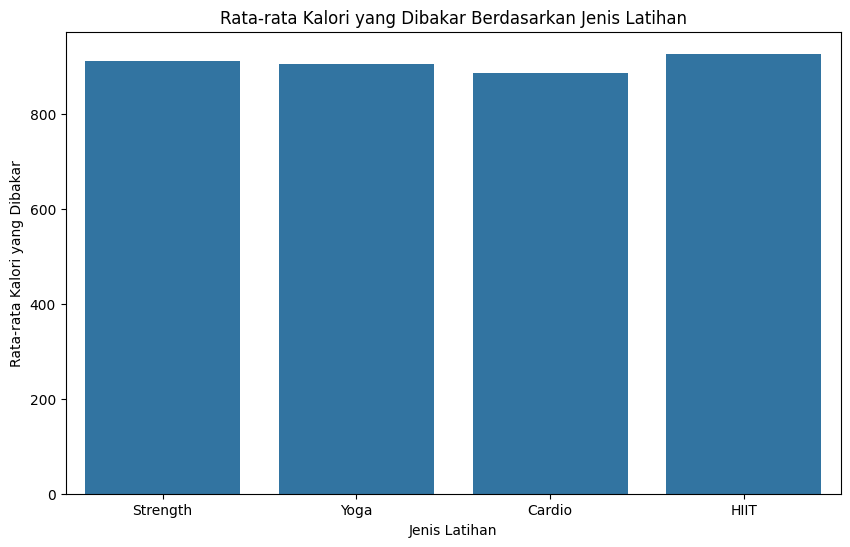

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Execute the Spark SQL query and convert the result to a Pandas DataFrame
avg_calories_burned_df = spark.sql('''
SELECT
    Workout_Type,
    AVG(Calories_Burned) AS Avg_Calories_Burned
FROM
    gym_members_exercise_tracking
GROUP BY
    Workout_Type;
''').toPandas()  # Convert to Pandas DataFrame

# Creating the visualization
plt.figure(figsize=(10, 6))
sns.barplot(x='Workout_Type', y='Avg_Calories_Burned', data=avg_calories_burned_df) # Use the new DataFrame here
plt.title('Rata-rata Kalori yang Dibakar Berdasarkan Jenis Latihan')
plt.xlabel('Jenis Latihan')
plt.ylabel('Rata-rata Kalori yang Dibakar')
plt.show()

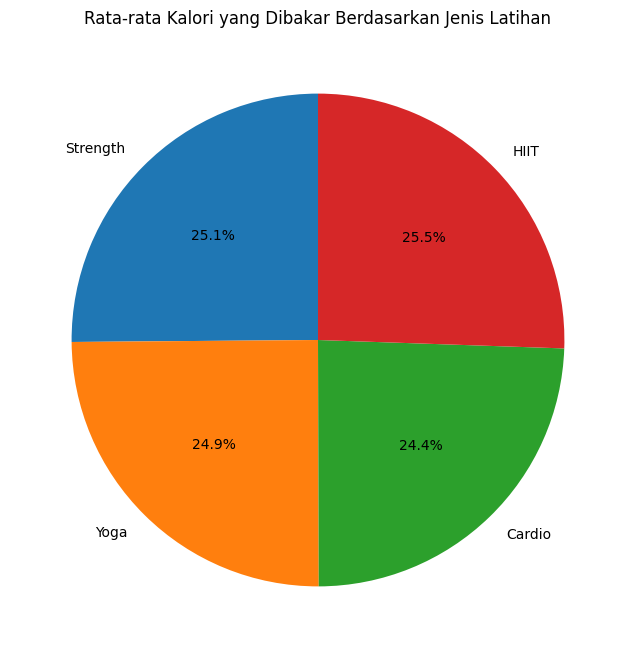

In [ ]:
import matplotlib.pyplot as plt

# Execute the Spark SQL query and convert the result to a Pandas DataFrame
avg_calories_burned_df = spark.sql('''
SELECT
    Workout_Type,
    AVG(Calories_Burned) AS Avg_Calories_Burned
FROM
    gym_members_exercise_tracking
GROUP BY
    Workout_Type;
''').toPandas()  # Convert to Pandas DataFrame

# Creating the pie chart
plt.figure(figsize=(8, 8))
plt.pie(avg_calories_burned_df['Avg_Calories_Burned'], labels=avg_calories_burned_df['Workout_Type'], autopct='%1.1f%%', startangle=90)
plt.title('Rata-rata Kalori yang Dibakar Berdasarkan Jenis Latihan')
plt.show()